In [1]:
from dotenv import load_dotenv
import os
import json
import re
from together import Together
from e2b_code_interpreter import Sandbox

load_dotenv()

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")

# Choose from the codegen models:

MODEL_NAME = "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"

SYSTEM_PROMPT = """You're a Python data scientist. You are given tasks to complete and you run Python code to solve them.

Information about the csv dataset:
- It's in the `/home/user/soci_econ_country_profiles.csv` file
- The CSV file is using , as the delimiter
- It has the following columns (examples included):
    - country: "Argentina", "Australia"
    - Region: "SouthAmerica", "Oceania"
    - Surface area (km2): for example, 2780400
    - Population in thousands (2017): for example, 44271
    - Population density (per km2, 2017): for example, 16.2
    - Sex ratio (m per 100 f, 2017): for example, 95.9
    - GDP: Gross domestic product (million current US$): for example, 632343
    - GDP growth rate (annual %, const. 2005 prices): for example, 2.4
    - GDP per capita (current US$): for example, 14564.5
    - Economy: Agriculture (% of GVA): for example, 10.0
    - Economy: Industry (% of GVA): for example, 28.1
    - Economy: Services and other activity (% of GVA): for example, 61.9
    - Employment: Agriculture (% of employed): for example, 4.8
    - Employment: Industry (% of employed): for example, 20.6
    - Employment: Services (% of employed): for example, 74.7
    - Unemployment (% of labour force): for example, 8.5
    - Employment: Female (% of employed): for example, 43.7
    - Employment: Male (% of employed): for example, 56.3
    - Labour force participation (female %): for example, 48.5
    - Labour force participation (male %): for example, 71.1
    - International trade: Imports (million US$): for example, 59253
    - International trade: Exports (million US$): for example, 57802
    - International trade: Balance (million US$): for example, -1451
    - Education: Government expenditure (% of GDP): for example, 5.3
    - Health: Total expenditure (% of GDP): for example, 8.1
    - Health: Government expenditure (% of total health expenditure): for example, 69.2
    - Health: Private expenditure (% of total health expenditure): for example, 30.8
    - Health: Out-of-pocket expenditure (% of total health expenditure): for example, 20.2
    - Health: External health expenditure (% of total health expenditure): for example, 0.2
    - Education: Primary gross enrollment ratio (f/m per 100 pop): for example, 111.5/107.6
    - Education: Secondary gross enrollment ratio (f/m per 100 pop): for example, 104.7/98.9
    - Education: Tertiary gross enrollment ratio (f/m per 100 pop): for example, 90.5/72.3
    - Education: Mean years of schooling (female): for example, 10.4
    - Education: Mean years of schooling (male): for example, 9.7
    - Urban population (% of total population): for example, 91.7
    - Population growth rate (annual %): for example, 0.9
    - Fertility rate (births per woman): for example, 2.3
    - Infant mortality rate (per 1,000 live births): for example, 8.9
    - Life expectancy at birth, female (years): for example, 79.7
    - Life expectancy at birth, male (years): for example, 72.9
    - Life expectancy at birth, total (years): for example, 76.4
    - Military expenditure (% of GDP): for example, 0.9
    - Population, female: for example, 22572521
    - Population, male: for example, 21472290
    - Tax revenue (% of GDP): for example, 11.0
    - Taxes on income, profits and capital gains (% of revenue): for example, 12.9
    - Urban population (% of total population): for example, 91.7

Generally, you follow these rules:
- ALWAYS FORMAT YOUR RESPONSE IN MARKDOWN
- ALWAYS RESPOND ONLY WITH CODE IN CODE BLOCK LIKE THIS:
      ```python
      {code}
      ```
   - the Python code runs in jupyter notebook.
   - every time you generate Python, the code is executed in a separate cell. it's okay to make multiple calls to `execute_python`.
   - display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
   - you have access to the internet and can make api requests.
   - you also have access to the filesystem and can read/write files.
   - you can install any pip package (if it exists) if you need to be running `!pip install {package}`. The usual packages for data analysis are already preinstalled though.
   - you can run any Python code you want, everything is running in a secure sandbox environment
   """

In [2]:
def code_interpret(sandbox, code):
    print("Running code interpreter...")
    
    execution = sandbox.run_code(
        code,
        on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
        on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
        # You can also stream code execution results
        # on_result=...
    )

    if execution.error:
        print("[Code Interpreter ERROR]", execution.error)
    else:
        return execution.results

import re
from together import Together

client = Together()

pattern = re.compile(
    r"```python\n(.*?)\n```", re.DOTALL
)  # Match everything in between ```python and ```

def match_code_blocks(llm_response):
    match = pattern.search(llm_response)
    if match:
        code = match.group(1)
        print(code)
        return code
    return ""

def chat_with_llm(sandbox, user_message):
    print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_message},
    ]

    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

    response_message = response.choices[0].message
    python_code = match_code_blocks(response_message.content)
    if python_code != "":
        code_interpreter_results = code_interpret(sandbox, python_code)
        return code_interpreter_results
    else:
        print(f"Failed to match any Python code in model's response {response_message}")
        return []


In [3]:
def upload_dataset(csv_fname, sandbox):
    print("Uploading dataset to Code Interpreter sandbox...")

    if not os.path.exists(csv_fname):
        raise FileNotFoundError("Dataset file not found")

    try:
        with open(csv_fname, "rb") as f:
            content = f.read()
            remote_path = f"/home/user/{os.path.basename(csv_fname)}"
            sandbox.files.write(remote_path, content)

        print("Uploaded at", remote_path)
        return remote_path
    except Exception as error:
        print("Error during file upload:", error)
        raise error

Uploading dataset to Code Interpreter sandbox...
Uploaded at /home/user/soci_econ_country_profiles.csv

User message: Make a chart showing linear regression of the relationship between GDP per capita and life expectancy from the data. Filter out any missing values or values in wrong format.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the data
df = pd.read_csv('/home/user/soci_econ_country_profiles.csv')

# Filter out missing values
df = df.dropna(subset=['GDP per capita (current US$)', 'Life expectancy at birth, total (years)'])

# Ensure the columns are in the correct format
df['GDP per capita (current US$)'] = pd.to_numeric(df['GDP per capita (current US$)'], errors='coerce')
df['Life expectancy at birth, total (years)'] = pd.to_numeric(df['Life expectancy at birth, total (years)'], errors='coerce')

# Filter out values in the wrong format
df = df.dropna(subset=['GDP per capita (current US$)', 'Life 

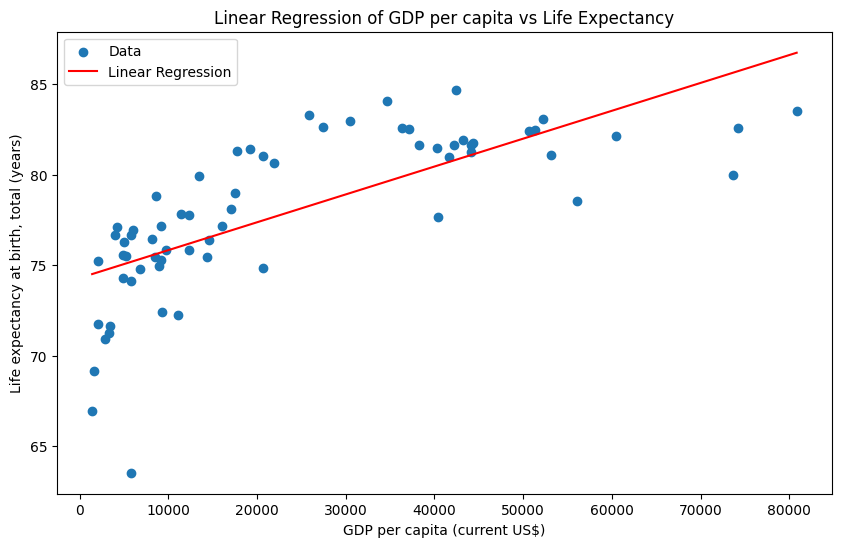

In [4]:
with Sandbox(api_key=E2B_API_KEY) as code_interpreter:
    # Upload the dataset to the code interpreter sandbox
    upload_dataset("soci_econ_country_profiles.csv", code_interpreter)

    code_results = chat_with_llm(
        code_interpreter,
        "Make a chart showing linear regression of the relationship between GDP per capita and life expectancy from the data. Filter out any missing values or values in wrong format.",
    )
    if code_results:
        first_result = code_results[0]
    else:
        raise Exception("No code interpreter results")


# This will render the image if you're running this in a notebook environment. 
# If you're running it as a script, you can save the image to a file using the Pillow library.
first_result